<a href="https://colab.research.google.com/github/btekgit/GaussianLayer/blob/master/GaussLayer_cifar10_Gauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# CODE for Gaussian Layer
!pwd

/content


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 13 19:07:34 2018
LAst update Jun 17 2019

@author: btek
"""
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras import activations, regularizers, constraints
from keras import initializers
from keras.engine import InputSpec
import numpy as np
import tensorflow as tf
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

Using TensorFlow backend.


In [0]:
def idx_init(shape, dtype='float32'):
    idxs = np.zeros((shape[0], shape[1]),dtype)
    c = 0
    # assumes square filters
    
    wid = np.int(np.sqrt(shape[0]))
    hei =np.int(np.sqrt(shape[0]))
    f = np.float32
    for x in np.arange(wid):  # / (self.incoming_width * 1.0):
        for y in np.arange(hei):  # / (self.incoming_height * 1.0):
            idxs[c, :] = np.array([x/f(wid-1), y/f(hei-1)],dtype)
            c += 1

    return idxs

def cov_init(shape, dtype='float32'):
    
    cov = np.identity(shape[1], dtype)
    # shape [0] must have self.incoming_channels * self.num_filters
    cov = np.repeat(cov[np.newaxis], shape[0], axis=0)
    
    #for t in range(shape[0]):
    #    cov[t] = cov[t]
    return cov

def scale_init(shape, dtype='float32'):
    #sc = np.linspace(0.5, 1.6, shape[0]) #best for mnist cluttered
    #sc = np.linspace(0.05, 0.1, shape[0],dtype=dtype) #best for mnist cluttered
    #sc = 0.05*np.ones(shape[0],dtype=dtype) #best for mnist cluttered
    sc = np.linspace(0.05, 0.1, shape[0],dtype=dtype)#tried on fashion mnist with no difference
    #sc=np.expand_dims(sc, axis=1)
    #sc=np.expand_dims(sc, axis=2)
    #print(sc)
    return sc

In [0]:
class GaussScaler(Layer):
    def __init__(self, rank, filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=False,
                 kernel_regularizer=None,
                 gain=1.0,
                 output_padding=None,
                 **kwargs):
        super(GaussScaler, self).__init__(**kwargs)
        #def __init__(self, num_filters, kernel_size, incoming_channels=1, **kwargs):
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = data_format
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.gain = gain
                 
        #self.input_shape = input_shape
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'))
        print(kwargs)
        self.kernel_size = kernel_size
        
        self.num_filters = filters
        #self.incoming_channels = incoming_channels
        
        
        self.output_padding = output_padding
        if self.output_padding is not None:
            self.output_padding = conv_utils.normalize_tuple(
                self.output_padding, 2, 'output_padding')
            for stride, out_pad in zip(self.strides, self.output_padding):
                if out_pad >= stride:
                    raise ValueError('Stride ' + str(self.strides) + ' must be '
                                     'greater than output padding ' +str(self.output_padding))
                    
        super(GaussScaler, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        
        self.input_channels = input_dim
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        print("kernel shape:",kernel_shape)

        self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
        # Create a trainable weight variable for this layer.
        
        kernel_size = self.kernel_size
        # Idxs Init
        
        
        
        
        #mu = np.array([kernel_size[0] // 2, kernel_size[1] // 2])
        mu = np.array([0.5, 0.5])


        # Convert Types
        self.mu = mu.astype(dtype='float32')

        # Shared Parameters
        # below works for only two dimensional cov 
        #self.cov = self.add_weight(shape=[input_dim*self.filters,2,2], 
        #                          name="cov", initializer=cov_init, trainable=False)
        
        
        self.cov_scaler = self.add_weight(shape=(self.filters,),
                                          name='scaler',initializer=scale_init,
                                          trainable=True,
                                          constraint= constraints.NonNeg())
                                  #constraint=constraints.non_neg())
        
        #print("Self.cov:",self.cov)
        #print("Self cov-scaler",self.cov_scaler)
        
        # below prepares a meshgrid. 
        #self.idxs = self.add_weight(shape=[kernel_size[0]*kernel_size[1],2], 
        #                           name="idxs", initializer=idx_init, trainable=False)
        
        self.idxs= idx_init(shape=[kernel_size[0]*kernel_size[1],2])
        
        super(GaussScaler, self).build(input_shape)  # Be sure to call this somewhere!
        
    
    def U(self):
  
        e1 = (self.idxs - self.mu)
        #print("e1.shape",e1.shape)
        #print("cov scaler shape",self.cov_scaler)
   
        #print(self.cov.shape)
        #print(len(tf.unstack(self.cov,axis=0)))
        #print( tf.linalg.inv(tf.unstack(self.cov,axis=0)[0]))
        # tensorflow does not need scan it does the same op to all covs.
        #cov_inv = self.cov
        #cov_scaled =self.cov_scaler*self.cov
#        cov_scaled = tf.scalar_mul(self.cov_scaler,self.cov)
#        print(self.cov.shape, self.cov_scaler.shape )
#        cov_scaled = K.batch_dot(self.cov_scaler,self.cov, axes=[1,2])
        #cov_inv = tf.linalg.inv(cov_scaled)
        #print("cov_scaled :",cov_scaled.shape)
        #cov_inv = K.map_fn(lambda x: tf.linalg.inv(x), elems=tf.unstack(self.cov,axis=0))
       

        #e2 = K.dot(e1, K.transpose(cov_inv))
        #ex = K.batch_dot(e2, e1, axes=[[1], [1]])
        #result = K.exp(-(1 / 2.0) * ex)

        up= K.sum((self.idxs - self.mu)**2, axis=1)
        #print("up.shape",up.shape)
        up = K.expand_dims(up,axis=1,)
        #print("up.shape",up.shape)
        # clipping scaler in range to prevent div by 0 or negative cov. 
        cov_scaler = K.clip(self.cov_scaler,0.01,5)
        #cov_scaler = self.cov_scaler
        dwn = 2 * (cov_scaler ** 2)
        #scaler = (np.pi*self.cov_scaler**2) * (self.idxs.shape[0])
        result = K.exp(-up / dwn)
        


        # Transpose is super important.
        #filter: A 4-D `Tensor` with the same type as `value` and shape
        #`[height, width, output_channels, in_channels]`
        # we do not care about input channels
        
        masks = K.reshape(result,(self.kernel_size[0],
                                  self.kernel_size[1],
                                  self.filters,1))   
            
        #sum normalization each filter has sum 1
        #sums = K.sum(masks**2, axis=(0, 1), keepdims=True)
        #print(sums)
        #gain = K.constant(self.gain, dtype='float32')
        masks /= K.sqrt(K.sum(K.square(masks), axis=(0, 1),keepdims=True))
        #masks /= K.sum(masks, axis=(0, 1),keepdims=True)
        #masks /= (self.kernel_size[0]*self.kernel_size[1])
        
        #masks *= (gain*np.sqrt(self.kernel_size[0]*self.kernel_size[1]))
        #ums = sums * sums
        #print("sums shape: ", sums.shape)
        
        # Sum normalisation
        
        #masks = masks * (gain/K.sqrt(sums))
        #masks = masks * (gain/sums)
        #print("masks shape", masks.shape)
        #print("masks mask", K.mean(masks))
        return masks



    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
          h_axis, w_axis = 2, 3
          c_axis= 1
          
        else:
            h_axis, w_axis = 1, 2
            c_axis=3
            
        ##BTEK 
        kernel = self.U()
        in_channels =input_shape[c_axis]
        
        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(height,
                                              stride_h, kernel_h,
                                              self.padding,
                                              out_pad_h,
                                              self.dilation_rate[0])
        out_width = conv_utils.deconv_length(width,
                                             stride_w, kernel_w,
                                             self.padding,
                                             out_pad_w,
                                             self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        ##BTEK 
        kernel = self.U()
        print("kernel shape in output:",kernel.shape)
        print("channel axis")
        kernel = K.repeat_elements(kernel, self.input_channels, axis=c_axis)
        print("kernel reshaped :",kernel.shape)
        #---------------------------------------------------------------------
        outputs = K.conv2d_transpose(
            inputs,
            kernel,
            output_shape,
            self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs


        
    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        if self.data_format == 'channels_first':
            c_axis, h_axis, w_axis = 1, 2, 3
        else:
            c_axis, h_axis, w_axis = 3, 1, 2

        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        output_shape[c_axis] = self.filters
        output_shape[h_axis] = conv_utils.deconv_length(output_shape[h_axis],
                                                        stride_h,
                                                        kernel_h,
                                                        self.padding,
                                                        out_pad_h,
                                                        self.dilation_rate[0])
        output_shape[w_axis] = conv_utils.deconv_length(output_shape[w_axis],
                                                        stride_w,
                                                        kernel_w,
                                                        self.padding,
                                                        out_pad_w,
                                                        self.dilation_rate[1])
        return tuple(output_shape)


In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input,Lambda, Concatenate
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD

import os

In [0]:
 # LOAD DATA

batch_size = 128
num_classes = 10
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'  

In [0]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


CREATE THE MODEL

In [0]:
# CREATE THE MODEL
nGauss = 4
n_input_channels=3
node_in  = Input(shape=input_shape)
if nGauss>0:
    if n_input_channels==3:
        pool_channels=[]
        for i in range(n_input_channels):
            # separate channels
            # use input directly at least in one channel
            g_c= Lambda(lambda x: K.expand_dims(x[:,:,:,i],axis=3), name='ChannelSeparator'+str(i))(node_in)
            gauss_pooled = GaussScaler(rank=2,filters=4,kernel_size=(5,5), 
                                 input_shape=input_shape, 
                                 padding='same',gain=1.0, name='gausslayer'+str(i))(g_c)

            pool_channels.append(gauss_pooled)
        node_pool1 = Concatenate(name='merge',axis=-1)(pool_channels)
        node_conv=Conv2D(32, kernel_size=(3, 3),activation='relu')(node_pool1)
    
    else:
        #=============================================================================
        gs=GaussScaler(rank=2,filters=nGauss,kernel_size=(5,5), 
                         data_format='channels_last',strides=1,
                         padding='same',name='gausslayer', activation='linear',
                         input_shape=input_shape)(node_in)
        #gs= BatchNormalization()(gs)
        node_conv=Conv2D(32, kernel_size=(3, 3),activation='relu')(gs)
#=============================================================================
else:
    node_conv=Conv2D(32, kernel_size=(3, 3),
                     activation='relu',input_shape=input_shape)(node_in)
  
node=Conv2D(32, (3, 3),activation='relu')(node_conv)
node=BatchNormalization()(node)

node=Conv2D(64, (3, 3),activation='relu',padding='same')(node)
node=BatchNormalization()(node)
node=MaxPooling2D(pool_size=(2, 2))(node)
node=Dropout(0.25)(node)

node=Conv2D(96, (3, 3),activation='relu',padding='same')(node)
node=BatchNormalization()(node)

node=MaxPooling2D(pool_size=(2, 2))(node)
node=Dropout(0.25)(node)

node=Flatten()(node)
node=Dense(512)(node)
node=Activation('relu')(node)
node=Dropout(0.5)(node)
node=Dense(num_classes)(node)
pred=Activation('softmax')(node)

model = Model(inputs=node_in, outputs=[pred])
model.summary()



W0618 08:02:14.558362 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 08:02:14.561628 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



{'input_shape': (32, 32, 3), 'name': 'gausslayer0'}
kernel shape: (5, 5, 1, 4)
kernel shape in output: (5, 5, 4, 1)
channel axis
kernel reshaped : (5, 5, 4, 1)
{'input_shape': (32, 32, 3), 'name': 'gausslayer1'}
kernel shape: (5, 5, 1, 4)
kernel shape in output: (5, 5, 4, 1)
channel axis
kernel reshaped : (5, 5, 4, 1)
{'input_shape': (32, 32, 3), 'name': 'gausslayer2'}
kernel shape: (5, 5, 1, 4)


W0618 08:02:14.816340 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 08:02:14.863960 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 08:02:14.865415 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



kernel shape in output: (5, 5, 4, 1)
channel axis
kernel reshaped : (5, 5, 4, 1)


W0618 08:02:15.485210 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0618 08:02:15.681276 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 08:02:15.692674 139788871563136 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
ChannelSeparator0 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ChannelSeparator1 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ChannelSeparator2 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
gausslayer

Plotting kernels before...
Sigmas before [0.05       0.06666667 0.08333334 0.1       ]
U shape (5, 5, 4, 1)
U max: 1.0


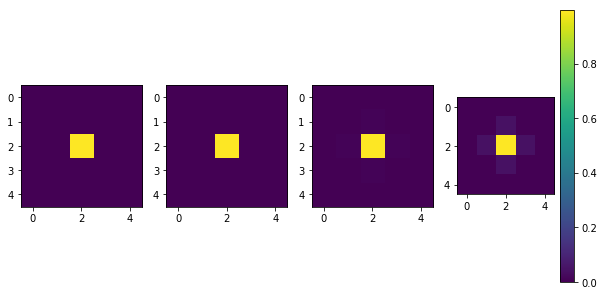

In [0]:
plt = True and nGauss>0
if plt:
    print("Plotting kernels before...")
    import matplotlib.pyplot as plt
    gauss_layer = model.get_layer('gausslayer0')
    ws = gauss_layer.get_weights()
    print("Sigmas before",ws[0])
    u_func = K.function(inputs=[model.input], outputs=[gauss_layer.U()])
    output_func = K.function(inputs=[model.input], outputs=[gauss_layer.output])

    U_val=u_func([np.expand_dims(x_test[0], axis=0)])
    
    print("U shape", U_val[0].shape)
    print("U max:", np.max(U_val[0][:,:,:,:]))
    num_filt=min(U_val[0].shape[2],12)
    fig=plt.figure(figsize=(10,5))
    for i in range(num_filt):
        ax1=plt.subplot(1, num_filt, i+1)
        im = ax1.imshow(np.squeeze(U_val[0][:,:,i,0]))
    fig.colorbar(im, ax=ax1)
    plt.show()

In [10]:

from lr_multiplier import LearningRateMultiplier

multipliers = {'gausslayer': 1.0} # no batch normalization is 0.1, batch norm requires larger learning rate???
opt = LearningRateMultiplier(SGD, lr_multipliers=multipliers, 
                             lr=0.01, momentum=0.9,decay=0.000005000)
# Higher decays hurt the process
print(opt)
#opt = SGD(lr=0.01,momentum=0.5)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

batch_size = 128

epochs = 100

steps_per_epoch = 60000/batch_size


if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

W0618 08:02:17.011099 139788871563136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
ChannelSeparator0 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ChannelSeparator1 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
ChannelSeparator2 (Lambda)      (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
gausslayer

W0618 08:02:17.616471 139788871563136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
469/468 [==============================] - 53s 112ms/step - loss: 1.8124 - acc: 0.3548 - val_loss: 1.7315 - val_acc: 0.4131
Epoch 2/100
 68/468 [===>..........................] - ETA: 36s - loss: 1.5729 - acc: 0.4323

KeyboardInterrupt: ignored

In [0]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

PLOT THE FILTERS

Plotting kernels after ...
U max: 1.0
Sigmas after [0.04945168 0.05052903 0.17554562 0.04526363]
U shape (5, 5, 4, 1)


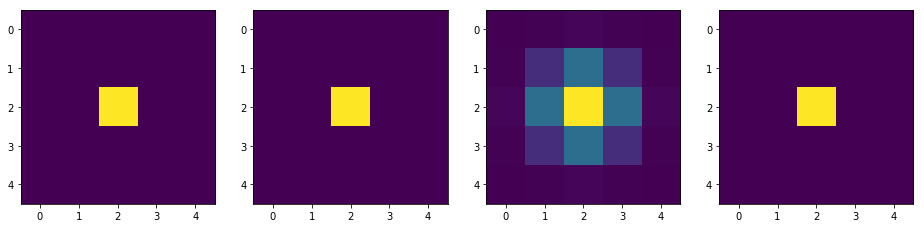

outputs  ...
Outputs shape (1, 32, 32, 4)
input mean,var,max 0.38357207 0.031253185 0.827451
ouput mean,var,max 0.53026396 0.027984126 0.8274598
ouput mean,var,max 0.5302681 0.027984517 0.8274661
ouput mean,var,max 1.2645123 0.1457591 1.9321104
ouput mean,var,max 0.53025866 0.027983626 0.8274517


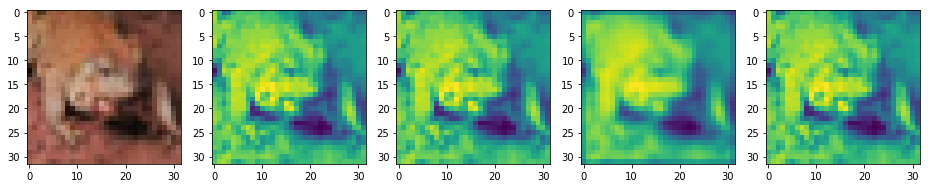

In [11]:
if plt:
    print("Plotting kernels after ...")
    
    print("U max:", np.max(U_val[0][:,:,:,:]))
    import matplotlib.pyplot as plt
    ws = gauss_layer.get_weights()
    print("Sigmas after",ws[0])
    U_val=u_func([np.expand_dims(x_test[2], axis=0)])
    
    print("U shape", U_val[0].shape)
    num_filt=min(U_val[0].shape[2],12)
    fig=plt.figure(figsize=(16,5))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt, i+1)
        im = ax.imshow(np.squeeze(U_val[0][:,:,i,0]))
    #fig.colorbar(im, ax=ax1)
    plt.show()
    
    
    print("outputs  ...")
    
    n=5
    
    out_val=output_func([np.expand_dims(x_test[5], axis=0)])
    print("Outputs shape", out_val[0].shape)
    num_filt=min(out_val[0].shape[3],12)
    fig=plt.figure(figsize=(16,10))
    ax=plt.subplot(1, num_filt+1, 1)
    im = ax.imshow(np.squeeze(x_test[5]))
    print("input mean,var,max",np.mean(x_test[5]),np.var(x_test[5]),np.max(x_test[5]))
    for i in range(num_filt):
        ax=plt.subplot(1, num_filt+1, i+2)
        out_im = out_val[0][0,:,:,i]
        im = ax.imshow(np.squeeze(out_im))
        print("ouput mean,var,max",np.mean(out_im),
                                       np.var(out_im),
                                       np.max(out_im))
        #plt.colorbar(im,ax=ax)
    plt.show()
    
    
    